# Financial Inclusion in Africa Starter Notebook


This is a simple starter notebook to get started with the Machine Learning for Financial Inclusion by University of Eswatini on Zindi.

This notebook covers:
- Loading the data
- Simple EDA and an example of feature enginnering
- Data preprocessing and data wrangling
- Creating a simple model
- Making a submission
- Some tips for improving your score

### Importing libraries

In [1]:
# dataframe and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#from google.colab import files
import warnings
warnings.filterwarnings('ignore')

### Read files

In [2]:
# Load files into a pandas dataframe
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
ss = pd.read_csv('SampleSubmission.csv')
variables = pd.read_csv('VariableDefinitions.csv')

### Some basic EDA

In [3]:
# Let's view the variables
variables

,Variable Definitions,Unnamed: 1
0,country,Country interviewee is in.
1,year,Year survey was done in.
2,uniqueid,Unique identifier for each interviewee
3,location_type,"Type of location: Rural, Urban"
4,cellphone_access,"If interviewee has access to a cellphone: Yes, No"
5,household_size,Number of people living in one house
6,age_of_respondent,The age of the interviewee
7,gender_of_respondent,"Gender of interviewee: Male, Female"
8,relationship_with_head,The interviewee’s relationship with the head o...
9,marital_status,The martial status of the interviewee: Married...


In [4]:
# Preview the first five rows of the train set
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [5]:
# Preview the first five rows of the test set
test.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent


In [6]:
# Preview the first five rows of the sample submission file
ss.head()

,unique_id,bank_account
0,uniqueid_1 x Kenya,0
1,uniqueid_2 x Kenya,0
2,uniqueid_3 x Kenya,0
3,uniqueid_4 x Kenya,0
4,uniqueid_5 x Kenya,0


In [7]:
# Check the shape of the train and test sets
print(f'The shape of the train set is: {train.shape}\nThe shape of the test set is: {test.shape}')

The shape of the train set is: (23524, 13)
The shape of the test set is: (10086, 12)


## Combine train and test set for easy preprocessing 

In [8]:
# mapping the bank account with 0 to NO and 1 to YES
train['bank_account'] = train['bank_account'].map({'No':0, 'Yes':1})

In [9]:
# Combine train and test set
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (33610, 13)


In [10]:
# Preview the last five rows of the combined dataframe
all_data.tail()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
33605,Uganda,2018,uniqueid_2998,NaN,Rural,No,2,62,Female,Spouse,Married/Living together,Primary education,Self employed
33606,Uganda,2018,uniqueid_2999,NaN,Urban,Yes,8,42,Male,Head of Household,Married/Living together,Primary education,Self employed
33607,Uganda,2018,uniqueid_3000,NaN,Urban,Yes,1,39,Male,Head of Household,Single/Never Married,Secondary education,Other Income
33608,Uganda,2018,uniqueid_3001,NaN,Rural,Yes,6,28,Female,Spouse,Married/Living together,Primary education,Self employed
33609,Uganda,2018,uniqueid_3002,NaN,Urban,Yes,7,16,Male,Other relative,Single/Never Married,Secondary education,Other Income


In [11]:
# function for categorzing age of respondents
def age_of_respondent_cat(x):
    if x < 40:
        return 'youth'
    elif x >= 35 and x < 65:
        return 'life'
    elif x >= 65:
        return 'old'

In [12]:
all_data['age_of_respondent'] = all_data['age_of_respondent'].apply(age_of_respondent_cat)

In [13]:
all_data['education_level'].replace(['No formal education', 'Primary education'], 'below_secondary', inplace=True)

In [14]:
all_data['education_level'].replace(['Tertiary education', 'Vocational/Specialised training'], 'Post secondary', inplace=True)

In [15]:
all_data['education_level'].replace('Other/Dont know/RTA', 'below_secondary', inplace=True)

In [13]:
# function for categorzing household size
def household_size_cat(x):
    if x <= 2:
        return 'small'
    elif x > 2 and x <= 4:
        return 'medium'
    elif x > 4:
        return 'big'

In [14]:
all_data['household_size'] = all_data['household_size'].apply(household_size_cat)

In [18]:
all_data['relationship_with_head'].replace(['Other relative','Other non-relatives'], 'other', inplace=True)

In [19]:
all_data['marital_status'].replace('Dont know', 'Divorced/Seperated', inplace=True)

In [20]:
# Check the column names and datatypes
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33610 entries, 0 to 33609
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country                 33610 non-null  object 
 1   year                    33610 non-null  int64  
 2   uniqueid                33610 non-null  object 
 3   bank_account            23524 non-null  float64
 4   location_type           33610 non-null  object 
 5   cellphone_access        33610 non-null  object 
 6   household_size          33610 non-null  object 
 7   age_of_respondent       33610 non-null  object 
 8   gender_of_respondent    33610 non-null  object 
 9   relationship_with_head  33610 non-null  object 
 10  marital_status          33610 non-null  object 
 11  education_level         33610 non-null  object 
 12  job_type                33610 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 3.3+ MB


### Number of unique values per categorical column

In [15]:
# Check unique values for each categorical column
cat_cols = ['household_size', 'age_of_respondent', 'year', 'country',	'location_type',	'cellphone_access',	'gender_of_respondent',	'relationship_with_head', 'marital_status', 'education_level',	'job_type']
for col in cat_cols:
  print(col)
  print(all_data[col].unique(), '\n')

household_size
['medium' 'big' 'small'] 

age_of_respondent
['youth' 'old' 'life'] 

year
[2018 2016 2017] 

country
['Kenya' 'Rwanda' 'Tanzania' 'Uganda'] 

location_type
['Rural' 'Urban'] 

cellphone_access
['Yes' 'No'] 

gender_of_respondent
['Female' 'Male'] 

relationship_with_head
['Spouse' 'Head of Household' 'Other relative' 'Child' 'Parent'
 'Other non-relatives'] 

marital_status
['Married/Living together' 'Widowed' 'Single/Never Married'
 'Divorced/Seperated' 'Dont know'] 

education_level
['Secondary education' 'No formal education'
 'Vocational/Specialised training' 'Primary education'
 'Tertiary education' 'Other/Dont know/RTA'] 

job_type
['Self employed' 'Government Dependent' 'Formally employed Private'
 'Informally employed' 'Formally employed Government'
 'Farming and Fishing' 'Remittance Dependent' 'Other Income'
 'Dont Know/Refuse to answer' 'No Income'] 



### Feature Engineering


#### Try different strategies of dealing with categorical variables
Tips:
 - One hot encoding
 - Label encoding
 - Target encoding
 - Reduce the number of unique values...

In [16]:
# Encode categorical features
all_data = pd.get_dummies(data = all_data, columns = cat_cols, drop_first=True)
all_data.head()

,uniqueid,bank_account,household_size_medium,household_size_small,age_of_respondent_old,age_of_respondent_youth,year_2017,year_2018,country_Rwanda,country_Tanzania,...,education_level_Vocational/Specialised training,job_type_Farming and Fishing,job_type_Formally employed Government,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed
0,uniqueid_1,1.0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,uniqueid_2,0.0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,uniqueid_3,1.0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
3,uniqueid_4,0.0,0,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,uniqueid_5,0.0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [17]:
# Separate train and test data from the combined dataframe
train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((23524, 37), (10086, 37))

### Training and making predictions
Tips:
- Is lgbm the best model for this challenge?
- Parameter tuning
 - Grid search, random search, perhaps bayesian search works better...



In [18]:
main_cols = all_data.columns.difference(['uniqueid', 'bank_account'])
main_cols

Index(['age_of_respondent_old', 'age_of_respondent_youth',
       'cellphone_access_Yes', 'country_Rwanda', 'country_Tanzania',
       'country_Uganda', 'education_level_Other/Dont know/RTA',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'gender_of_respondent_Male', 'household_size_medium',
       'household_size_small', 'job_type_Farming and Fishing',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent',
       'job_type_Self employed', 'location_type_Urban',
       'marital_status_Dont know', 'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'relationship_with_head_Hea

In [19]:
# Select main columns to be used in training
#main_cols = all_data.columns.difference(date_cols+['ID', 'bank_account'])
#main_cols = all_data.columns.difference('bank_account')
X = train_df[main_cols]
y = train_df['bank_account']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [20]:
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [21]:
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(Counter(y_train))

Counter({0.0: 14139, 1.0: 14139})


In [22]:
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test=sc.transform(X_test)

In [23]:
# checking extratreeclassifier

from sklearn.ensemble import ExtraTreesClassifier

# Train model
et_clf = ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                                criterion='gini', max_depth=110, max_features='sqrt',
                                max_leaf_nodes=None, max_samples=None,
                                min_impurity_decrease=0.0, min_impurity_split=None,
                                min_samples_leaf=1, min_samples_split=5,
                                min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=-1,
                                oob_score=False, random_state=123, verbose=0,
                                warm_start=False)

et_clf.fit(X_train, y_train)

# Make predictions
y_pred = et_clf.predict(X_test)

# Check the accuracy score of the model
#accuracy_score(y_pred,y_test)
from sklearn.metrics import classification_report,confusion_matrix
# classification report
print('classification report:')
print(' ')
print(classification_report(y_test,y_pred))
# confusion matrix
print('confusion matrix:')
print(' ')
cm=confusion_matrix(y_test,y_pred)
print(cm)
print ("Accuracy of prediction:",round((cm[0,0]+cm[1,1])/cm.sum(),3))
print(' ')
print('accuracy_score: ',accuracy_score(y_pred,y_test))

classification report:
 
              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90      6073
         1.0       0.43      0.55      0.48       985

    accuracy                           0.84      7058
   macro avg       0.68      0.72      0.69      7058
weighted avg       0.86      0.84      0.84      7058

confusion matrix:
 
[[5364  709]
 [ 444  541]]
Accuracy of prediction: 0.837
 
accuracy_score:  0.8366392745820346


In [24]:
from sklearn.linear_model import RidgeClassifier


rig_clf = RidgeClassifier(normalize=False, random_state=100, tol=0.1)
rig_clf.fit(X_train, y_train)

# Make predictions
y_pred = rig_clf.predict(X_test)

# Check the accuracy score of the model
#accuracy_score(y_pred,y_test)
from sklearn.metrics import classification_report,confusion_matrix
# classification report
print('classification report:')
print(' ')
print(classification_report(y_test,y_pred))
# confusion matrix
print('confusion matrix:')
print(' ')
cm=confusion_matrix(y_test,y_pred)
print(cm)
print ("Accuracy of prediction:",round((cm[0,0]+cm[1,1])/cm.sum(),3))
print(' ')
print('accuracy_score: ',accuracy_score(y_pred,y_test))

classification report:
 
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92      6073
         1.0       0.00      0.00      0.00       985

    accuracy                           0.86      7058
   macro avg       0.43      0.50      0.46      7058
weighted avg       0.74      0.86      0.80      7058

confusion matrix:
 
[[6073    0]
 [ 985    0]]
Accuracy of prediction: 0.86
 
accuracy_score:  0.8604420515726835


In [25]:
from catboost import CatBoostClassifier

In [26]:
# checking catboost
# Train model
cb_clf = CatBoostClassifier(verbose=False)
cb_clf.fit(X_train, y_train)

# Make predictions
y_pred = cb_clf.predict(X_test)

# Check the accuracy score of the model
#accuracy_score(y_pred,y_test)
from sklearn.metrics import classification_report,confusion_matrix
# classification report
print('classification report:')
print(' ')
print(classification_report(y_test,y_pred))
# confusion matrix
print('confusion matrix:')
print(' ')
cm=confusion_matrix(y_test,y_pred)
print(cm)
print ("Accuracy of prediction:",round((cm[0,0]+cm[1,1])/cm.sum(),3))
print(' ')
print('accuracy_score: ',accuracy_score(y_pred,y_test))

classification report:
 
              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91      6073
         1.0       0.45      0.63      0.53       985

    accuracy                           0.84      7058
   macro avg       0.69      0.75      0.72      7058
weighted avg       0.87      0.84      0.85      7058

confusion matrix:
 
[[5323  750]
 [ 366  619]]
Accuracy of prediction: 0.842
 
accuracy_score:  0.8418815528478323


In [27]:
# checking gradientboostingclassifier

from sklearn.ensemble import GradientBoostingClassifier

# Train model
gb_clf = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                                    learning_rate=0.29, loss='deviance', max_depth=80,
                                    max_features='auto', max_leaf_nodes=None,
                                    min_impurity_decrease=0.0, min_impurity_split=None,
                                    min_samples_leaf=2, min_samples_split=10,
                                    min_weight_fraction_leaf=0.0, n_estimators=55,
                                    n_iter_no_change=None,
                                    random_state=123, subsample=0.6500000000000001,
                                    tol=0.0001, validation_fraction=0.1, verbose=0,
                                    warm_start=False)
gb_clf.fit(X_train, y_train)

# Make predictions
y_pred = gb_clf.predict(X_test)

# Check the accuracy score of the model
#accuracy_score(y_pred,y_test)
from sklearn.metrics import classification_report,confusion_matrix
# classification report
print('classification report:')
print(' ')
print(classification_report(y_test,y_pred))
# confusion matrix
print('confusion matrix:')
print(' ')
cm=confusion_matrix(y_test,y_pred)
print(cm)
print ("Accuracy of prediction:",round((cm[0,0]+cm[1,1])/cm.sum(),3))
print(' ')
print('accuracy_score: ',accuracy_score(y_pred,y_test))

classification report:
 
              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90      6073
         1.0       0.41      0.54      0.47       985

    accuracy                           0.83      7058
   macro avg       0.67      0.71      0.68      7058
weighted avg       0.85      0.83      0.84      7058

confusion matrix:
 
[[5326  747]
 [ 456  529]]
Accuracy of prediction: 0.83
 
accuracy_score:  0.8295551147633891


In [28]:
#checking lgbmclassifier
# Train model
model = LGBMClassifier(boosting_type='gbdt', objective='binary', class_weight=None, colsample_bytree=1.0,
                        importance_type='split', learning_rate=0.1, max_depth=30,
                        min_child_samples=20, min_child_weight=0.001, min_split_gain=0,
                        n_estimators=100, n_jobs=-1, num_leaves=70, metric ='auc',
                        random_state=123, reg_alpha=0.1, reg_lambda=0.5, silent=True,
                        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Check the accuracy score of the model
#accuracy_score(y_pred,y_test)
from sklearn.metrics import classification_report,confusion_matrix
# classification report
print('classification report:')
print(' ')
print(classification_report(y_test,y_pred))
# confusion matrix
print('confusion matrix:')
print(' ')
cm=confusion_matrix(y_test,y_pred)
print(cm)
print ("Accuracy of prediction:",round((cm[0,0]+cm[1,1])/cm.sum(),3))
print(' ')
print('accuracy_score: ',accuracy_score(y_pred,y_test))

classification report:
 
              precision    recall  f1-score   support

         0.0       0.94      0.87      0.90      6073
         1.0       0.45      0.64      0.53       985

    accuracy                           0.84      7058
   macro avg       0.69      0.76      0.72      7058
weighted avg       0.87      0.84      0.85      7058

confusion matrix:
 
[[5301  772]
 [ 355  630]]
Accuracy of prediction: 0.84
 
accuracy_score:  0.8403230376877302


In [29]:
#checking logistic regression
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(C=100, penalty= 'l2', solver= 'liblinear')

# C=1.94, class_weight=None, dual=False, fit_intercept=True,
#                             intercept_scaling=1, l1_ratio=None, max_iter=100,
#                             multi_class='auto', n_jobs=-1, penalty='l2',
#                             random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
#                             warm_start=False

lr_clf.fit(X_train, y_train)

# Make predictions
y_pred = lr_clf.predict(X_test)

# Check the accuracy score of the model
#accuracy_score(y_pred,y_test)
from sklearn.metrics import classification_report,confusion_matrix
# classification report
print('classification report:')
print(' ')
print(classification_report(y_test,y_pred))
# confusion matrix
print('confusion matrix:')
print(' ')
cm=confusion_matrix(y_test,y_pred)
print(cm)
print ("Accuracy of prediction:",round((cm[0,0]+cm[1,1])/cm.sum(),3))
print(' ')
print('accuracy_score: ',accuracy_score(y_pred,y_test))

classification report:
 
              precision    recall  f1-score   support

         0.0       0.93      0.89      0.91      6073
         1.0       0.46      0.59      0.52       985

    accuracy                           0.85      7058
   macro avg       0.70      0.74      0.71      7058
weighted avg       0.87      0.85      0.85      7058

confusion matrix:
 
[[5404  669]
 [ 406  579]]
Accuracy of prediction: 0.848
 
accuracy_score:  0.8476905638991216


In [30]:
# checking naive bayes

from sklearn.naive_bayes import GaussianNB
nb_clf= GaussianNB()
nb_clf.fit(X_train, y_train)
           
# Make predictions
y_pred = nb_clf.predict(X_test)

# Check the accuracy score of the model
#accuracy_score(y_pred,y_test)
from sklearn.metrics import classification_report,confusion_matrix
# classification report
print('classification report:')
print(' ')
print(classification_report(y_test,y_pred))
# confusion matrix
print('confusion matrix:')
print(' ')
cm=confusion_matrix(y_test,y_pred)
print(cm)
print ("Accuracy of prediction:",round((cm[0,0]+cm[1,1])/cm.sum(),3))
print(' ')
print('accuracy_score: ',accuracy_score(y_pred,y_test))

classification report:
 
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.93      6073
         1.0       0.74      0.02      0.04       985

    accuracy                           0.86      7058
   macro avg       0.80      0.51      0.48      7058
weighted avg       0.85      0.86      0.80      7058

confusion matrix:
 
[[6066    7]
 [ 965   20]]
Accuracy of prediction: 0.862
 
accuracy_score:  0.8622839331255313


In [31]:
#checking randomforestclassifier

from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=23,
                               min_samples_split=5, n_estimators=103, n_jobs=-1,
                               random_state=123)
    


#RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
#criterion='entropy', max_depth=20, max_features='auto',
#max_leaf_nodes=None, max_samples=None,
#min_impurity_decrease=0.0, min_impurity_split=None,
#min_samples_leaf=2, min_samples_split=7,
#min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
#oob_score=False, random_state=123, verbose=0,
#warm_start=False)

rf_clf.fit(X_train, y_train)
#'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 25
# Make predictions
y_pred = rf_clf.predict(X_test)

# Check the accuracy score of the model
#accuracy_score(y_pred,y_test)
from sklearn.metrics import classification_report,confusion_matrix
# classification report
print('classification report:')
print(' ')
print(classification_report(y_test,y_pred))
# confusion matrix
print('confusion matrix:')
print(' ')
cm=confusion_matrix(y_test,y_pred)
print(cm)
print ("Accuracy of prediction:",round((cm[0,0]+cm[1,1])/cm.sum(),3))
print(' ')
print('accuracy_score: ',accuracy_score(y_pred,y_test))

classification report:
 
              precision    recall  f1-score   support

         0.0       0.93      0.89      0.91      6073
         1.0       0.45      0.56      0.50       985

    accuracy                           0.84      7058
   macro avg       0.69      0.72      0.70      7058
weighted avg       0.86      0.84      0.85      7058

confusion matrix:
 
[[5392  681]
 [ 433  552]]
Accuracy of prediction: 0.842
 
accuracy_score:  0.842164919240578


In [37]:
# checking logistic plus random forest

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier



voting_clf3 = VotingClassifier(
 estimators=[('lr', lr_clf),('rf', rf_clf)],
 voting='hard')
voting_clf3.fit(X_train, y_train)

# Make predictions
y_pred = voting_clf3.predict(X_test)

# Check the accuracy score of the model
#accuracy_score(y_pred,y_test)
from sklearn.metrics import classification_report,confusion_matrix
# classification report
print('classification report:')
print(' ')
print(classification_report(y_test,y_pred))
# confusion matrix
print('confusion matrix:')
print(' ')
cm=confusion_matrix(y_test,y_pred)
print(cm)
print ("Accuracy of prediction:",round((cm[0,0]+cm[1,1])/cm.sum(),3))
print(' ')
print('accuracy_score: ',accuracy_score(y_pred,y_test))

classification report:
 
              precision    recall  f1-score   support

         0.0       0.91      0.94      0.92      6073
         1.0       0.53      0.43      0.47       985

    accuracy                           0.87      7058
   macro avg       0.72      0.68      0.70      7058
weighted avg       0.86      0.87      0.86      7058

confusion matrix:
 
[[5698  375]
 [ 563  422]]
Accuracy of prediction: 0.867
 
accuracy_score:  0.8671011618022103


In [40]:
# logistic plus catboost
voting_clf4 = VotingClassifier(
 estimators=[('ridge', rig_clf), ('rf', rf_clf)],
 voting='hard'
)
voting_clf4.fit(X_train, y_train)

# Make predictions
y_pred = voting_clf4.predict(X_test)

# Check the accuracy score of the model
#accuracy_score(y_pred,y_test)
from sklearn.metrics import classification_report,confusion_matrix
# classification report
print('classification report:')
print(' ')
print(classification_report(y_test,y_pred))
# confusion matrix
print('confusion matrix:')
print(' ')
cm=confusion_matrix(y_test,y_pred)
print(cm)
print ("Accuracy of prediction:",round((cm[0,0]+cm[1,1])/cm.sum(),3))
print(' ')
print('accuracy_score: ',accuracy_score(y_pred,y_test))

classification report:
 
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92      6073
         1.0       0.00      0.00      0.00       985

    accuracy                           0.86      7058
   macro avg       0.43      0.50      0.46      7058
weighted avg       0.74      0.86      0.80      7058

confusion matrix:
 
[[6073    0]
 [ 985    0]]
Accuracy of prediction: 0.86
 
accuracy_score:  0.8604420515726835


In [39]:
# logistic plus lgbmclassifier
voting_clf4 = VotingClassifier(
 estimators=[('lr', lr_clf), ('lgbm', model)],
 voting='hard'
)
voting_clf4.fit(X_train, y_train)

# Make predictions
y_pred = voting_clf4.predict(X_test)

# Check the accuracy score of the model
#accuracy_score(y_pred,y_test)
from sklearn.metrics import classification_report,confusion_matrix
# classification report
print('classification report:')
print(' ')
print(classification_report(y_test,y_pred))
# confusion matrix
print('confusion matrix:')
print(' ')
cm=confusion_matrix(y_test,y_pred)
print(cm)
print ("Accuracy of prediction:",round((cm[0,0]+cm[1,1])/cm.sum(),3))
print(' ')
print('accuracy_score: ',accuracy_score(y_pred,y_test))

classification report:
 
              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92      6073
         1.0       0.53      0.46      0.50       985

    accuracy                           0.87      7058
   macro avg       0.72      0.70      0.71      7058
weighted avg       0.86      0.87      0.86      7058

confusion matrix:
 
[[5675  398]
 [ 528  457]]
Accuracy of prediction: 0.869
 
accuracy_score:  0.8688013601586851


In [40]:
# view the feature scores for randomforest

feature_scores = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

location_type_Urban                         558
gender_of_respondent_Male                   392
household_size_medium                       378
age_of_respondent_youth                     354
household_size_small                        302
year_2018                                   296
education_level_Secondary education         289
marital_status_Married/Living together      268
job_type_Informally employed                261
country_Uganda                              256
education_level_below_secondary             249
marital_status_Single/Never Married         246
relationship_with_head_Head of Household    245
job_type_Self employed                      245
age_of_respondent_old                       227
job_type_Remittance Dependent               226
cellphone_access_Yes                        208
job_type_Farming and Fishing                201
job_type_Formally employed Private          199
country_Rwanda                              193
marital_status_Widowed                  

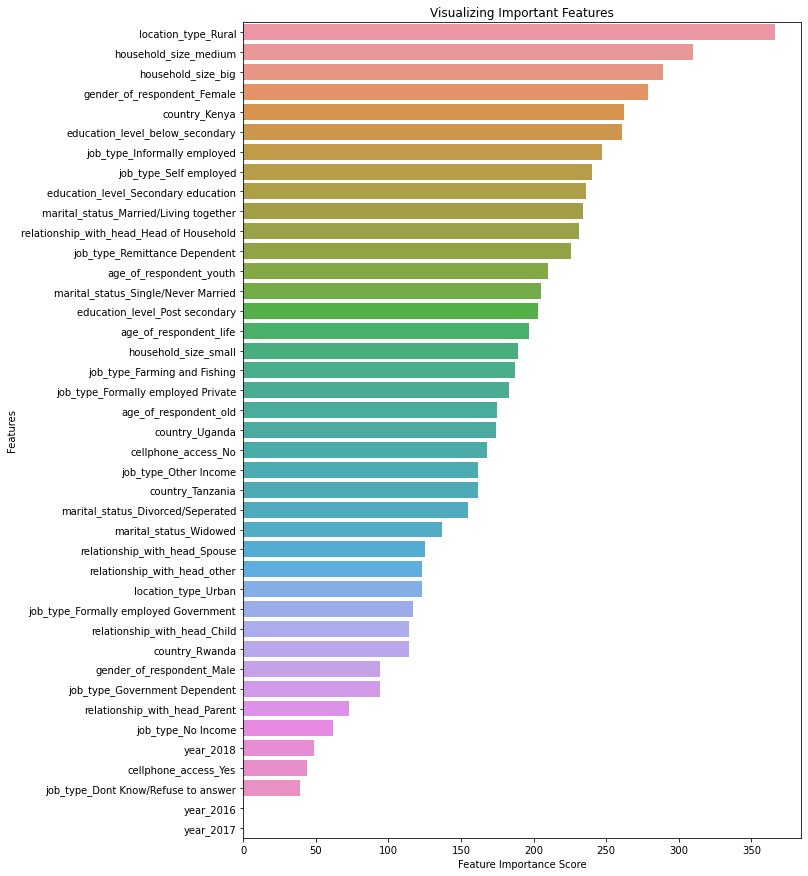

In [42]:
# Creating a seaborn bar plot
plt.figure(figsize=(10,15))
sns.barplot(x=feature_scores, y=feature_scores.index)



# Add labels to the graph

plt.xlabel('Feature Importance Score')

plt.ylabel('Features')



# Add title to the graph

plt.title("Visualizing Important Features")



# Visualize the graph

plt.show()

### Making predictions of the test set and creating a submission file

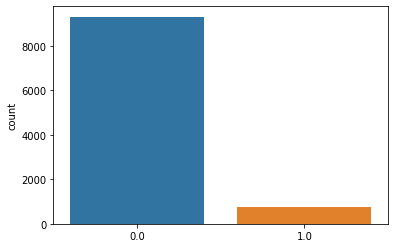

In [19]:
# Make prediction on the test set
test_df = test_df[main_cols]
predictions = model.predict(test_df)

# Create a submission file
sub_file = ss.copy()
sub_file.predictions = predictions

# Check the distribution of your predictions
sns.countplot(sub_file.predictions);

In [20]:
# Create a csv file and upload to zindi 
sub_file.to_csv('Baseline.csv', index = False)

In [21]:
files.download('Baseline.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###More Tips
- Thorough EDA and domain knowledge sourcing
- Re-group Categorical features 
- More Feature Engineering 
- Dataset balancing - oversampling, undersampling, SMOTE...
- Ensembling of models 
- Cross-validation: Group folds, Stratified...

# ******************* GOOD LUCK!!! ***************************